<a href="https://colab.research.google.com/github/DaDupe01/Milestone2AccelerationDawoduMA/blob/main/LoanQualificationAccelerationDawoduModupeola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bankcustomer4monthtransaction_new.csv to bankcustomer4monthtransaction_new.csv


In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
df_clean = df.drop(df.columns[df.columns.str.contains('Unnamed', case=False)], axis=1)

NameError: name 'df' is not defined

In [6]:
df = pd.read_csv('bankcustomer4monthtransaction_new.csv')
display(df.head())

,TRAN_DATE,CUSTOMER_ID,TRANSACTION_REMARK,AMOUNT
0,24-Oct-24,C_106630397RTL,1054850016DILSTAFFSALARIE,"19,398,779.25"
1,24-Oct-24,C_52188263RTL,1054850015DILSTAFFSALARIE,"14,327,691.97"
2,24-Oct-24,C_6904606RTL,STAFF SALARY OCT 2024,"13,163,255.25"
3,29-Oct-24,C_38332985RTL,STAFF SALARY OCT 2024,"10,557,607.63"
4,25-Oct-24,C_17730243RTL,STAFF SALARY FOR OCTOBER,"10,289,437.81"


In [11]:
# Drop rows where 'TRANSACTION_REMARK' is missing, as these are the same rows
# that have missing 'AMOUNT' and 'TRAN_DATE' values
df_clean = df.dropna(subset=['TRANSACTION_REMARK']).copy()

In [15]:
# Clean and convert the 'AMOUNT' column. Note: The column name has a leading space.
df_clean.rename(columns={' AMOUNT ': 'AMOUNT'}, inplace=True)
df_clean.loc[:, 'AMOUNT'] = df_clean['AMOUNT'].astype(str).str.replace(',', '').astype(float)

/tmp/ipython-input-777211177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.rename(columns={' AMOUNT ': 'AMOUNT'}, inplace=True)


In [17]:
# Convert TRAN_DATE to datetime objects
df_clean.loc[:, 'TRAN_DATE'] = pd.to_datetime(df_clean['TRAN_DATE'], format='%d-%b-%y')

In [19]:
# Remove the 'RTL' suffix from CUSTOMER_ID
df_clean.loc[:, 'CUSTOMER_ID'] = df_clean['CUSTOMER_ID'].str.replace('RTL', '')

In [32]:
# Create a boolean column to identify salary transactions
keywords = ['salary', 'sal', 'dilstaff', 'payroll', 'wages']
df_clean.loc[:, 'Is_Salary'] = df_clean['TRANSACTION_REMARK'].str.lower().str.contains('|'.join(keywords), na=False)

# Make a simplifying assumption: salary transactions are credit, all others are debit
df_clean.loc[:, 'Signed_Amount'] = np.where(df_clean['Is_Salary'], df_clean['AMOUNT'], -df_clean['AMOUNT'])

# Aggregate the data by CUSTOMER_ID
customer_data = df_clean.groupby('CUSTOMER_ID').agg(
    total_credit=('AMOUNT', lambda x: x[df_clean.loc[x.index, 'Is_Salary']].sum()),
    total_debit=('AMOUNT', lambda x: x[~df_clean.loc[x.index, 'Is_Salary']].sum()),
    net_balance=('Signed_Amount', 'sum'),
    num_transactions=('AMOUNT', 'count'),
    num_salary_inflows=('Is_Salary', 'sum'),
    avg_salary_amount=('AMOUNT', lambda x: x[df_clean.loc[x.index, 'Is_Salary']].mean()),
    min_salary_amount=('AMOUNT', lambda x: x[df_clean.loc[x.index, 'Is_Salary']].min()),
).reset_index()

In [34]:
# 1. Number of customers who receive minimum salary above 30,000
customers_min_salary_above_30k = customer_data[customer_data['min_salary_amount'] > 30000]
num_customers_min_salary_above_30k = len(customers_min_salary_above_30k)

print(f"1. Number of customers who receive minimum salary above 30,000: {num_customers_min_salary_above_30k:,}")
print("-" * 50)

1. Number of customers who receive minimum salary above 30,000: 28,374
--------------------------------------------------


In [35]:
print("Top 5 customers by Customer ID and their minimum salary:")
display(customer_data[['CUSTOMER_ID', 'min_salary_amount']].head())

print("\nLast 5 customers by Customer ID and their minimum salary:")
display(customer_data[['CUSTOMER_ID', 'min_salary_amount']].tail())

Top 5 customers by Customer ID and their minimum salary:


,CUSTOMER_ID,min_salary_amount
0,C_1000042794,"53,409.48"
1,C_1000059848,"64,998.91"
2,C_1000066600,"82,568.64"
3,C_1000074809,"71,080.46"
4,C_1000082675,"71,189.33"



Last 5 customers by Customer ID and their minimum salary:


,CUSTOMER_ID,min_salary_amount
32341,C_9981145,"170,757.55"
32342,C_9983077,"112,535.00"
32343,C_9983747,"126,958.28"
32344,C_9992390,"98,435.62"
32345,C_9998811,"65,271.38"


In [45]:
# Loan Terms:
# Interest Rate (annual) = 35%
# Tenor (months) = 12
# Debt Service Ratio (DSR) = 33.3%
annual_interest_rate = 0.35
monthly_interest_rate = annual_interest_rate / 12
debt_service_ratio = 0.333
max_loan_cap = 5000000
min_loan_amount = 5000

# Function to calculate the maximum eligible loan amount
def calculate_loan_amount(min_salary):
    if min_salary <= 0:
        return 0
    monthly_payment = min_salary * debt_service_ratio
    eligible_loan_amount = monthly_payment * (1 - (1 + monthly_interest_rate)**-12) / monthly_interest_rate
    # Apply minimum loan amount
    if eligible_loan_amount > 0 and eligible_loan_amount < min_loan_amount:
        return min_loan_amount
    return eligible_loan_amount

# Apply the function to the filtered DataFrame to get a new column
customers_min_salary_above_30k.loc[:, 'max_eligible_loan_amount'] = customers_min_salary_above_30k['min_salary_amount'].apply(calculate_loan_amount)

# Apply the maximum loan cap
customers_min_salary_above_30k.loc[:, 'capped_eligible_loan_amount'] = customers_min_salary_above_30k['max_eligible_loan_amount'].apply(lambda x: min(x, max_loan_cap))


print("3. Maximum Eligible Loan Amount per customer (sample):")
display(customers_min_salary_above_30k.head())

print("-" * 50)
print("Summary for the least minimum salary:")

3. Maximum Eligible Loan Amount per customer (sample):


,CUSTOMER_ID,total_credit,total_debit,net_balance,num_transactions,num_salary_inflows,avg_salary_amount,min_salary_amount,max_eligible_loan_amount,capped_eligible_loan_amount
0,C_1000042794,"127,626.66",0.00,"127,626.66",2,2,"63,813.33","53,409.48","177,919.42","177,919.42"
1,C_1000059848,"152,530.88",0.00,"152,530.88",2,2,"76,265.44","64,998.91","216,526.51","216,526.51"
2,C_1000066600,"188,700.25",0.00,"188,700.25",2,2,"94,350.12","82,568.64","275,055.38","275,055.38"
3,C_1000074809,"147,112.12",0.00,"147,112.12",2,2,"73,556.06","71,080.46","236,785.57","236,785.57"
4,C_1000082675,"149,516.35",0.00,"149,516.35",2,2,"74,758.18","71,189.33","237,148.24","237,148.24"


--------------------------------------------------
Summary for the least minimum salary:


In [40]:
# Calculate for the single overall minimum salary as a summary
overall_least_min_salary = customer_data['min_salary_amount'].min()

if overall_least_min_salary > 0:
    summary_monthly_payment = overall_least_min_salary * debt_service_ratio
    summary_eligible_loan_amount = summary_monthly_payment * (1 - (1 + monthly_interest_rate)**-12) / monthly_interest_rate
    print(f"   - Overall Least Minimum Salary: ${overall_least_min_salary:,.2f}")
    print(f"   - Maximum Monthly Payment: ${summary_monthly_payment:,.2f}")
    print(f"   - Maximum Eligible Loan Amount: ${summary_eligible_loan_amount:,.2f}")
else:
    print("   - Cannot calculate loan amount as the least minimum salary is not a positive value.")

   - Overall Least Minimum Salary: $1.00
   - Maximum Monthly Payment: $0.33
   - Maximum Eligible Loan Amount: $3.33


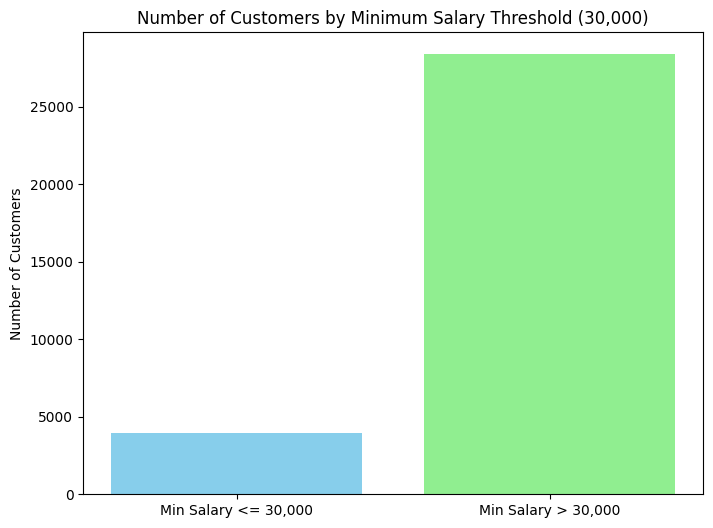

In [41]:
import matplotlib.pyplot as plt

# Calculate the number of customers with minimum salary below or equal to 30,000
num_customers_min_salary_below_30k = len(customer_data[customer_data['min_salary_amount'] <= 30000])

# Create labels and counts for the bar chart
labels = ['Min Salary <= 30,000', 'Min Salary > 30,000']
counts = [num_customers_min_salary_below_30k, num_customers_min_salary_above_30k]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightgreen'])
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Minimum Salary Threshold (30,000)')
plt.show()

In [42]:
print(f"Number of customers with minimum salary below or equal to 30,000: {num_customers_min_salary_below_30k:,}")
print(f"Number of customers with minimum salary above 30,000: {num_customers_min_salary_above_30k:,}")

Number of customers with minimum salary below or equal to 30,000: 3,959
Number of customers with minimum salary above 30,000: 28,374


In [46]:
total_potential_loan_amount = customers_min_salary_above_30k['capped_eligible_loan_amount'].sum()

print(f"The potential total maximum loan amount for customers with minimum salary above 30,000 is: ${total_potential_loan_amount:,.2f}")

The potential total maximum loan amount for customers with minimum salary above 30,000 is: $16,194,304,014.48


In [48]:
# Define the loan eligibility bands
bins = [5000, 1000000, 2000000, 3000000, 4000000, 5000000, float('inf')]
labels = ['5000 - 999999.99', '1000000 - 1999999.99', '2000000 - 2999999.99',
          '3000000 - 3999999.99', '4000000 - 4999999.99', '5000000']

# Categorize customers into bands based on capped_eligible_loan_amount
customers_min_salary_above_30k.loc[:, 'loan_eligibility_band'] = pd.cut(customers_min_salary_above_30k['capped_eligible_loan_amount'], bins=bins, labels=labels, right=False, include_lowest=True)

# Calculate total loan amount, number of customers, and percentage contribution per band
loan_band_summary = customers_min_salary_above_30k.groupby('loan_eligibility_band').agg(
    total_loan_amount=('capped_eligible_loan_amount', 'sum'),
    num_customers=('CUSTOMER_ID', 'count')
).reset_index()

# Calculate percentage contribution
total_loan_amount_all_bands = loan_band_summary['total_loan_amount'].sum()
loan_band_summary.loc[:, 'percentage_contribution'] = (loan_band_summary['total_loan_amount'] / total_loan_amount_all_bands) * 100

# Add a total row
total_row = pd.DataFrame({
    'loan_eligibility_band': ['Total'],
    'total_loan_amount': [loan_band_summary['total_loan_amount'].sum()],
    'num_customers': [loan_band_summary['num_customers'].sum()],
    'percentage_contribution': [loan_band_summary['percentage_contribution'].sum()]
})

loan_band_summary = pd.concat([loan_band_summary, total_row], ignore_index=True)

# Display the table
print("Loan Eligibility Band Summary:")
display(loan_band_summary)

Loan Eligibility Band Summary:


/tmp/ipython-input-3423224764.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_band_summary = customers_min_salary_above_30k.groupby('loan_eligibility_band').agg(


,loan_eligibility_band,total_loan_amount,num_customers,percentage_contribution
0,5000 - 999999.99,"9,149,780,633.55",24989,56.50
1,1000000 - 1999999.99,"2,957,068,021.25",2178,18.26
2,2000000 - 2999999.99,"1,347,879,497.13",544,8.32
3,3000000 - 3999999.99,"1,127,060,694.34",329,6.96
4,4000000 - 4999999.99,"487,515,168.20",109,3.01
5,5000000,"1,125,000,000.00",225,6.95
6,Total,"16,194,304,014.48",28374,100.00


from matplotlib import pyplot as plt
loan_band_summary['total_loan_amount'].plot(kind='hist', bins=20, title='total_loan_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary['num_customers'].plot(kind='hist', bins=20, title='num_customers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary['percentage_contribution'].plot(kind='hist', bins=20, title='percentage_contribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
loan_band_summary.groupby('loan_eligibility_band').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary.plot(kind='scatter', x='total_loan_amount', y='num_customers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary.plot(kind='scatter', x='num_customers', y='percentage_contribution', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary['total_loan_amount'].plot(kind='line', figsize=(8, 4), title='total_loan_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary['num_customers'].plot(kind='line', figsize=(8, 4), title='num_customers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
loan_band_summary['percentage_contribution'].plot(kind='line', figsize=(8, 4), title='percentage_contribution')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(loan_band_summary['loan_eligibility_band'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(loan_band_summary, x='total_loan_amount', y='loan_eligibility_band', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(loan_band_summary['loan_eligibility_band'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(loan_band_summary, x='num_customers', y='loan_eligibility_band', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(loan_band_summary['loan_eligibility_band'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(loan_band_summary, x='percentage_contribution', y='loan_eligibility_band', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

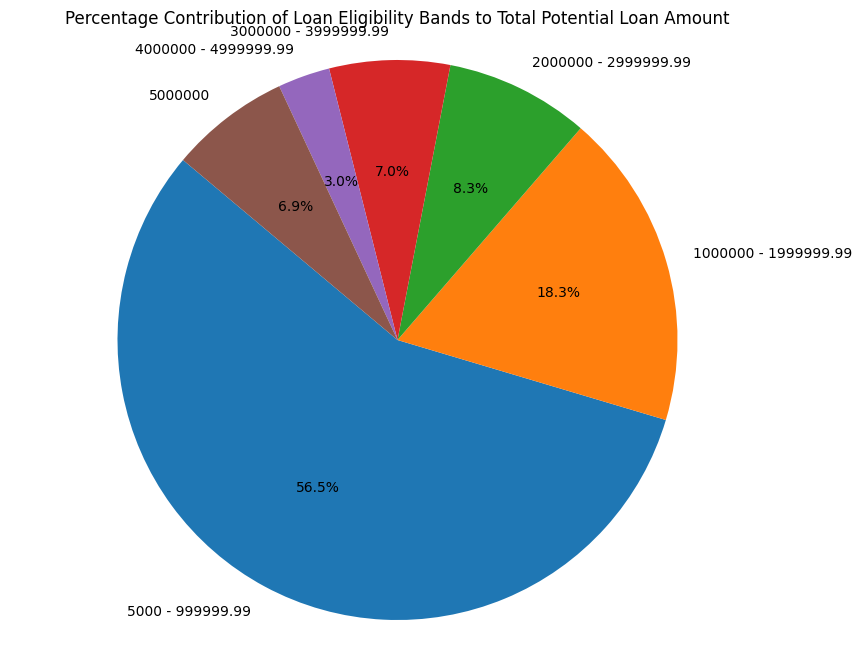

In [49]:
import matplotlib.pyplot as plt

# Exclude the 'Total' row for the pie chart
loan_band_summary_plot = loan_band_summary[loan_band_summary['loan_eligibility_band'] != 'Total'].copy()

plt.figure(figsize=(10, 8))
plt.pie(loan_band_summary_plot['percentage_contribution'], labels=loan_band_summary_plot['loan_eligibility_band'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage Contribution of Loan Eligibility Bands to Total Potential Loan Amount')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [50]:
management_fee_rate = 0.01
total_management_fee = total_potential_loan_amount * management_fee_rate

print(f"The total management fee (at a 1% rate) would be: ${total_management_fee:,.2f}")

The total management fee (at a 1% rate) would be: $161,943,040.14


In [51]:
# Function to calculate the total interest for a loan
def calculate_total_interest(principal, annual_interest_rate, tenor_months):
    if principal <= 0:
        return 0
    monthly_interest_rate = annual_interest_rate / 12
    # Calculate monthly payment using the loan payment formula
    # M = P [ r(1 + r)^n ] / [ (1 + r)^n – 1]
    # Where M = Monthly Payment, P = Principal Loan Amount, r = Monthly Interest Rate, n = Tenor in Months
    if monthly_interest_rate > 0:
        monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate)**tenor_months) / ((1 + monthly_interest_rate)**tenor_months - 1)
    else:
        monthly_payment = principal / tenor_months # Simple division if interest is zero

    total_paid = monthly_payment * tenor_months
    total_interest = total_paid - principal
    return total_interest

# Apply the function to the customers_min_salary_above_30k DataFrame
customers_min_salary_above_30k.loc[:, 'total_interest_earned'] = customers_min_salary_above_30k['capped_eligible_loan_amount'].apply(
    lambda x: calculate_total_interest(x, annual_interest_rate, 12)
)

# Calculate the sum of total interest earned across all eligible customers
total_interest_across_all_customers = customers_min_salary_above_30k['total_interest_earned'].sum()

print(f"The total interest to be earned over 12 months if all eligible customers are onboarded is: ${total_interest_across_all_customers:,.2f}")

The total interest to be earned over 12 months if all eligible customers are onboarded is: $3,231,668,070.92


/tmp/ipython-input-1217960812.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_min_salary_above_30k.loc[:, 'total_interest_earned'] = customers_min_salary_above_30k['capped_eligible_loan_amount'].apply(


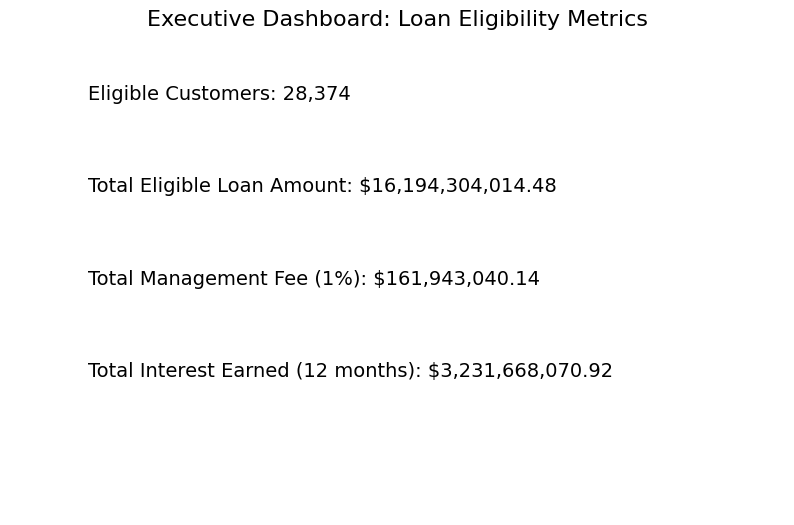

In [53]:
import matplotlib.pyplot as plt

# Prepare the data for visualization
metrics = {
    'Eligible Customers': num_customers_min_salary_above_30k,
    'Total Eligible Loan Amount': total_potential_loan_amount,
    'Total Management Fee (1%)': total_management_fee,
    'Total Interest Earned (12 months)': total_interest_across_all_customers
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('off')

# Define positions for the text
x_pos = 0.1
y_pos_start = 0.9
y_pos_increment = 0.2

# Add text annotations for each metric
for i, (label, value) in enumerate(metrics.items()):
    y_pos = y_pos_start - i * y_pos_increment
    if label == 'Eligible Customers':
        ax.text(x_pos, y_pos, f'{label}: {value:,}', fontsize=14, ha='left')
    else:
        ax.text(x_pos, y_pos, f'{label}: ${value:,.2f}', fontsize=14, ha='left')


ax.set_title('Executive Dashboard: Loan Eligibility Metrics', fontsize=16, pad=20)

plt.show()